In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Rankings

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'NFLX']
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Adj Close']

weekly_returns = data.pct_change(periods=5).dropna()

rankings = weekly_returns.rank(axis=1, method='min')

# Metric - High ranks (underperformers) get high scores for long positions
# basically a reverse rankoing - highest rank gets highest score
scores = rankings.apply(lambda x: len(tickers) - x)
scores

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,GOOGL,JPM,MSFT,NFLX
Date,,,,,
2020-01-09 00:00:00+00:00,1.0,0.0,4.0,3.0,2.0
2020-01-10 00:00:00+00:00,1.0,0.0,4.0,2.0,3.0
2020-01-13 00:00:00+00:00,0.0,1.0,4.0,2.0,3.0
2020-01-14 00:00:00+00:00,0.0,2.0,4.0,1.0,3.0
2020-01-15 00:00:00+00:00,0.0,1.0,4.0,2.0,3.0
...,...,...,...,...,...
2023-12-22 00:00:00+00:00,4.0,0.0,2.0,3.0,1.0
2023-12-26 00:00:00+00:00,4.0,0.0,1.0,3.0,2.0
2023-12-27 00:00:00+00:00,4.0,0.0,1.0,2.0,3.0


## Simple stat arb

In [3]:
# create equal numbers of long and short positions
num_long = num_short = len(tickers) // 2

long_positions = scores.iloc[-1].nlargest(num_long).index  # Last row, top scores for long positions
short_positions = scores.iloc[-1].nsmallest(num_short).index  # Last row, low scores for short positions

portfolio_weights = pd.Series(0, index=tickers)

portfolio_weights[long_positions] = 1 / num_long

portfolio_weights[short_positions] = -1 / num_short

print("Long Positions:", long_positions)
print("Short Positions:", short_positions)
print("Portfolio Weights:", portfolio_weights)

Long Positions: Index(['AAPL', 'NFLX'], dtype='object', name='Ticker')
Short Positions: Index(['JPM', 'MSFT'], dtype='object', name='Ticker')
Portfolio Weights: AAPL     0.5
MSFT    -0.5
GOOGL    0.0
JPM     -0.5
NFLX     0.5
dtype: float64


/var/folders/w8/1f8bwyyx1ws53fvmw1lcp4vm0000gn/T/ipykernel_8067/356191498.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_weights[long_positions] = 1 / num_long


In [4]:
data

Ticker,AAPL,GOOGL,JPM,MSFT,NFLX
Date,,,,,
2020-01-02 00:00:00+00:00,72.876122,68.264961,122.104607,153.938202,329.809998
2020-01-03 00:00:00+00:00,72.167618,67.907852,120.493294,152.021423,325.899994
2020-01-06 00:00:00+00:00,72.742668,69.717865,120.397453,152.414337,335.829987
2020-01-07 00:00:00+00:00,72.400543,69.583206,118.350616,151.024689,330.750000
2020-01-08 00:00:00+00:00,73.565201,70.078476,119.273865,153.430267,339.260010
...,...,...,...,...,...
2023-12-22 00:00:00+00:00,192.868134,141.140518,163.495834,372.543915,486.760010
2023-12-26 00:00:00+00:00,192.320221,141.170441,164.462753,372.623505,491.190002
2023-12-27 00:00:00+00:00,192.419830,140.023270,165.449173,372.036713,491.790009


## Backtesting

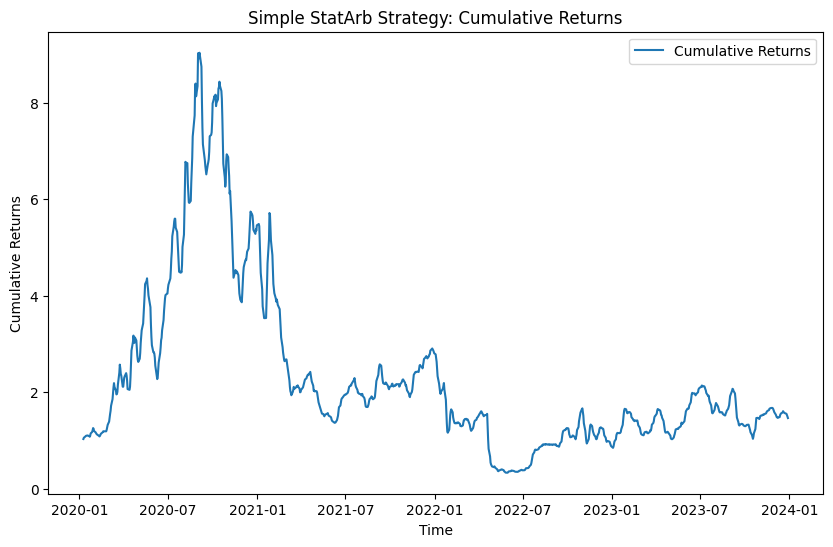

In [5]:
portfolio_returns = (portfolio_weights * weekly_returns).sum(axis=1)

cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Cumulative Returns')
plt.title('Simple StatArb Strategy: Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

## Using Mean Reversion Principles

In [6]:
rolling_mean = data.rolling(window=30).mean()
rolling_std = data.rolling(window=30).std()

# How far the current price is from the rolling mean
z_scores = (data - rolling_mean) / rolling_std

# Mean-reversion
# Go long when the price is far below the mean, short when it's above
threshold = 2 # TODO: change this to a better more informed number

signals = np.where(z_scores > threshold, -1, np.where(z_scores < -threshold, 1, 0))

signals_df = pd.DataFrame(signals, index=z_scores.index, columns=z_scores.columns)

num_long = num_short = len(data.columns) // 2  # Half of the assets

latest_z_scores = z_scores.iloc[-1]

long_positions = latest_z_scores.nsmallest(num_long).index


short_positions = latest_z_scores.nlargest(num_short).index

print("Long Positions:", long_positions)
print("Short Positions:", short_positions)

portfolio_weights = pd.Series(0, index=data.columns)

portfolio_weights[long_positions] = 1 / num_long
portfolio_weights[short_positions] = -1 / num_short

print("Portfolio Weights:")
print(portfolio_weights)

Long Positions: Index(['AAPL', 'MSFT'], dtype='object', name='Ticker')
Short Positions: Index(['JPM', 'GOOGL'], dtype='object', name='Ticker')
Portfolio Weights:
Ticker
AAPL     0.5
GOOGL   -0.5
JPM     -0.5
MSFT     0.5
NFLX     0.0
dtype: float64


/var/folders/w8/1f8bwyyx1ws53fvmw1lcp4vm0000gn/T/ipykernel_8067/3233542583.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_weights[long_positions] = 1 / num_long


## Backtesting

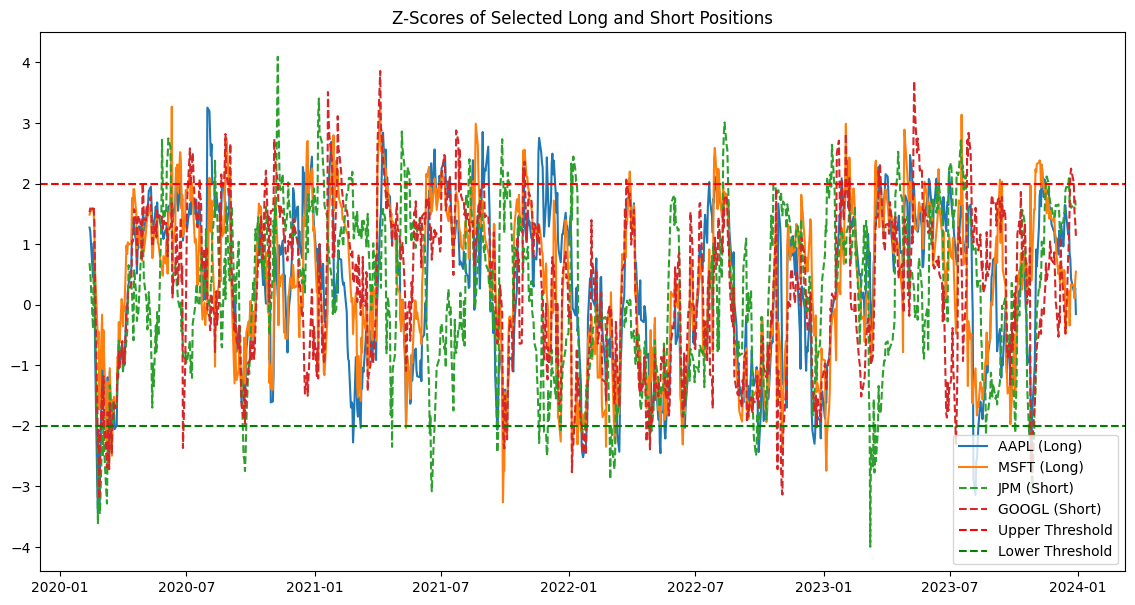

In [7]:
plt.figure(figsize=(14, 7))
for ticker in long_positions:
    plt.plot(z_scores[ticker], label=f'{ticker} (Long)')

for ticker in short_positions:
    plt.plot(z_scores[ticker], label=f'{ticker} (Short)', linestyle='--')

plt.axhline(threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-threshold, color='green', linestyle='--', label='Lower Threshold')
plt.title('Z-Scores of Selected Long and Short Positions')
plt.legend()
plt.show()

In [8]:
# Portfolio Simulation

returns = data.pct_change().dropna()
portfolio_returns = (signals_df.shift(1) * returns).mean(axis=1)

cumulative_returns = (1 + portfolio_returns).cumprod() - 1

risk_free_rate = 0.02 / 252  # 2% annual risk-free rate, 252 trading days

excess_returns = portfolio_returns - risk_free_rate
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

wins = (portfolio_returns > 0).sum()
losses = (portfolio_returns < 0).sum()
win_loss_ratio = wins / losses

rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

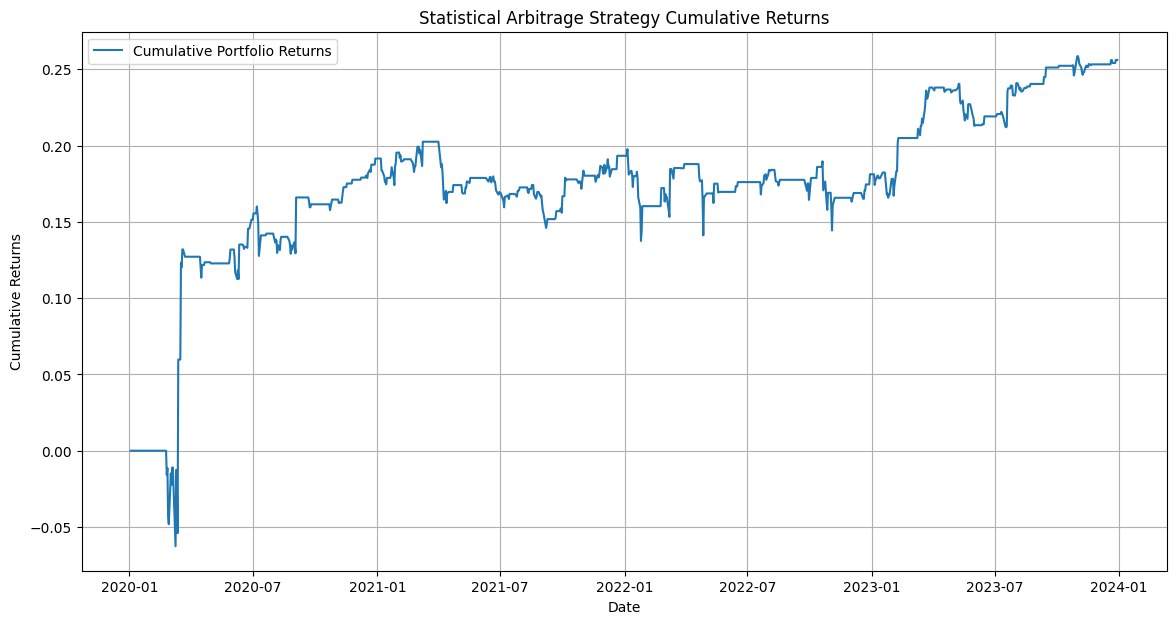

Sharpe Ratio: 0.43
Win/Loss Ratio: 1.08
Max Drawdown: -inf%


In [9]:
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Cumulative Portfolio Returns')
plt.title('Statistical Arbitrage Strategy Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")